# **Anomaly Detection: Esempio di Applicazione Industriale (pt. 1)**

L'obiettivo di notebook è quello di analizzare un problema reale di controllo qualità all'interno di una catena di montaggio automatica e di proporre un modello di Machine Learning in grado elaborare le immagini dei pezzi prodotti al fine di riconoscere quelli difettosi.



## **Analisi del Dataset**

Il dataset iniziale è composto da un totale di 132 esempi così suddivisi:

- 101 immagini di pezzi "normali" detti anche OK
- 21 immagini di pezzi difettosi detti anche KO

Ogni immagine raffigura un tubo di acciaio sul quale sono applicate 2 clip metalliche, i pezzi KO sono caratterizzati dall'assenza di una di queste.

![](images/esempio_pezzi.png)

**Attenzione**: Il tubo in acciaio non è sempre centrato all'interno dell'immagine, questo infatti è soggetto a *tolleranze di posizione e rotazione*, a causa delle imperfezioni delle saldature.

## **Formulazione del problema**

Il dataset a disposizione mostra un forte sbilanciamento in favore degli esempi di pezzi OK, mentre la classe KO risulta poco rappresentata.

Al fine di poter proporre un modello che sia meno sensibile a tale sbilanciamento, si vuole formulare il problema come un caso di Anomaly Detection, per cui le immagini di pezzi OK rappresentano l'insieme di dati considerati normali, mentre i pezzi KO rappresentano le anomalie che si vogliono identificare.

## **Caricamento delle immagini**

Al fine di semplificare la gestione dei dati durante il processo di addestramento e valutazione del modello, le immagini che compongono il dataset iniziali sono organizzate in 3 sotto-gruppi:

- 91 esempi di pezzi OK compongono l'insieme di dati riservati al training del modello
- le restanti 10 immagini di pezzi OK verranno utilizzate per i test successivi all'addestramento
- i 21 esempi di KO compogono un dataset a parte.

In [41]:
import os, random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [42]:
data_path = "dataset/clip_dataset"

Mostriamo qualche esempio a disposizione.

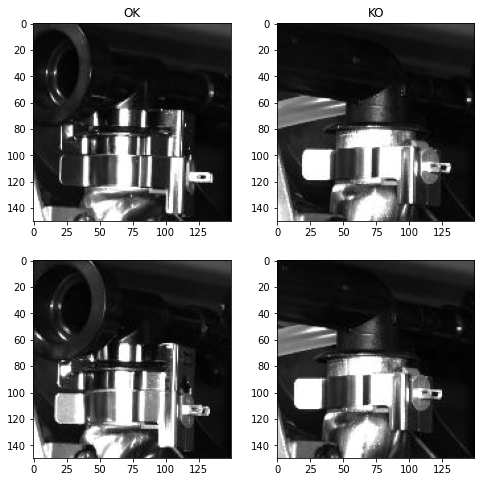

In [43]:
n_samples = 2

_, axs = plt.subplots(n_samples, 2, figsize=(8,8))
axs = axs.flatten()

samples = []

for i in range(n_samples):

  filename = random.choice(os.listdir(data_path + "/train/OK"))
  filename = os.path.join(data_path + "/train/OK", filename)

  with Image.open(filename) as test_ok:
    img_size = test_ok.size
    img = np.array(test_ok)
    img.reshape(img_size)
    samples.append(img)


  filename = random.choice(os.listdir(data_path + "/anomalies/KO"))
  filename = os.path.join(data_path + "/anomalies/KO", filename)

  with Image.open(filename) as test_ko:
    img_size = test_ko.size
    img = np.array(test_ko)
    img.reshape(img_size)
    samples.append(img)

axs[0].set_title("OK")
axs[1].set_title("KO")

for sample, ax in zip(samples, axs):
    ax.imshow(sample, cmap="gray")

plt.show()

Carichiamo le immagini secondo la suddivisione nei 3 sotto-dataset.

Dal momento in cui il numero di esempi per il training del modello è limitato, possiamo sfruttare le tolleranze di posizione e rotazione del tubo per generare, per mezzo di funzioni di Data Augmentation, degli ulteriori esempi verosimili.

In [44]:
from keras.preprocessing.image import ImageDataGenerator

In [45]:
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range = 5.0,
                                   width_shift_range = 0.05,
                                   height_shift_range = 0.05,
                                   validation_split = 0.1) # Data Augmentation
# Generatore di immagini di training dei pezzi OK
train_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input',
    subset = "training" )
# Generatore di immagini di validazione dei pezzi OK
valid_generator = train_datagen.flow_from_directory(
    data_path + "/train",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input',
    subset = "validation" )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi OK
test_generator = test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input' )

anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# Generatore di immagini di test di pezzi KO 
anomaly_generator = anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale",
    class_mode='input' )

Found 82 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


## **Implementazione del Modello**

Il modello scelto per la risoluzione del problema consiste in una rete neurale convolutiva di tipo Autoencoder.

Il vantaggio di questa tipologia di rete è che la fase di addestramento richiede l'utilizzo dei soli esempi di dati normali.

Ottimizzando il modello esclusivamente per la ricostruzione dei pezzi OK, ci si aspetta che, una volta completato l'addestramento, l'errore di ricostruzione sulle immagini di questi sia sensibilmente minore rispetto all'errore commesso sulle anomalie, consentendone così il riconoscimento.

### **Definizione**

In [46]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, Input, BatchNormalization, Lambda
from keras.models import Model, load_model
import tensorflow.keras.backend as K

Definiamo una classe di utilità per l'implementazione di un Autoencoder.

In [47]:
class Autoencoder():
    
    def __init__(self, image_size = (128,128,1), filename = None) -> None:
      if filename != None:
        self.model = load_model(filename)
      else:
        self.build(image_size)

    def generate_encoder_layer(layer_input, filters = 8, kernel_size = 3, pool_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di encoding.

        Tale insieme è composto da:
        - 2 layer convolutivi
        - 1 layer che implementa la funzione di attivazione LeakyReLU
        - 1 layer di normalizzazione
        - 1 layer di Max Pooling
      """

      conv = Conv2D(filters, kernel_size, padding = "same")(layer_input)
      conv = Conv2D(filters, kernel_size, padding = "same")(conv)
      conv = LeakyReLU(alpha = 0.2)(conv)
      norm_conv = BatchNormalization(momentum = 0.8)(conv)
      pool = MaxPooling2D(pool_size = pool_size)(norm_conv)

      return pool

    def generate_decoder_layer(layer_input, filters = 8, kernel_size = 3, up_sampling_size = (2,2)):
      """
        Restituisce un "pacchetto" di layer che implementa un singolo step di decoding.

        Tale insieme è composto da:
        - 1 layer di Up Sampling
        - 1 layer di concatenazione che realizza la skip-connection
        - 2 layer convolutivi con funzione di attivazione ReLU
      """
        
      layer = UpSampling2D(size = up_sampling_size)(layer_input)
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)
      layer = Conv2D(filters, kernel_size, activation = 'relu', padding = 'same')(layer)

      return layer

    def build(self, input_shape = (128,128,1)):
      '''
        Costruisce il modello
      '''

      # --- Definizione della Struttura ---

      input_layer = Input(shape=input_shape)

      encode1 = Autoencoder.generate_encoder_layer(input_layer, 16, 3)
      encode2 = Autoencoder.generate_encoder_layer(encode1, 32, 3)
      encode3 = Autoencoder.generate_encoder_layer(encode2, 32, 3)
      encode4 = Autoencoder.generate_encoder_layer(encode3, 64, 3)

      conv = Conv2D(128, 3, padding = "same", activation="relu")(encode4)

      decode1 = Autoencoder.generate_decoder_layer(conv, 64, 3)
      decode2 = Autoencoder.generate_decoder_layer(decode1, 32, 3)
      decode3 = Autoencoder.generate_decoder_layer(decode2, 32, 3)
      decode4 = Autoencoder.generate_decoder_layer(decode3, 16, 3)
 
      output = Conv2D(1, 3, padding="same", activation="tanh")(decode4)

      # Funzione di costo = Distanza euclidea tra l'immagine di input ed il risultato della ricostruzione
      loss = Lambda(lambda x: K.sqrt(K.sum((x[0] - x[1]) ** 2)),
                                name = "rec_error_loss")([input_layer, output])

      # --- Compilazione del Modello ---

      self.model = Model(inputs = input_layer, outputs = [loss, output])

      self.model.add_loss(K.mean(loss))
      self.model.add_metric(loss, aggregation='mean', name="rec_error_loss")

      self.model.compile(optimizer = "adam")

    def get_trained_autoencoder(self):
      """
        Restituisce un modello che esegue la ricostruzione delle immagini
      """
      return Model(inputs = self.model.inputs[0], outputs = self.model.outputs[1])

    def get_recostruction_error(self):
      """
        Restituisce un modello che calcola l'errore di ricostruzione
      """
      return Model(inputs = self.model.inputs[0], outputs = self.model.outputs[0])

    def train(self, train_generator, epochs = 10, steps_per_epoch = 10, valid_generator = None, validation_steps = 2):
      if valid_generator != None:
        return self.model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = validation_steps,
                              shuffle = True)
      else:
        return self.model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              shuffle = True)

    def summary(self):
      self.model.summary()

    def save(self, filename):
      self.model.save(filename)

Utilizzare la **Distanza Euclidea** come funzione di costo, garantisce che durante l'addestramnento il modello venga ottimizzato per ricostruire il più fedelmente possibile le immagini in input.

In [63]:
model = Autoencoder()
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_18[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 128, 128, 16) 0           conv2d_19[0][0]                  
___________________________________________________________________________________________

### **Training**

Procediamo con l'addestramento della rete.

In [64]:
train_generator.reset()
test_generator.reset()

history = model.train(train_generator,
          steps_per_epoch=10,
          epochs=50,
          valid_generator=valid_generator,
          validation_steps=1)

Epoch 1/50
10/10 [==============================] - 3s 146ms/step - loss: 102.4027 - rec_error_loss: 92.7923 - val_loss: 98.0761 - val_rec_error_loss: 98.0761
Epoch 2/50
10/10 [==============================] - 1s 103ms/step - loss: 69.1548 - rec_error_loss: 65.5881 - val_loss: 67.2113 - val_rec_error_loss: 67.2113
Epoch 3/50
10/10 [==============================] - 1s 110ms/step - loss: 60.0248 - rec_error_loss: 59.6987 - val_loss: 63.1511 - val_rec_error_loss: 63.1511
Epoch 4/50
10/10 [==============================] - 1s 107ms/step - loss: 58.9292 - rec_error_loss: 56.4614 - val_loss: 58.7835 - val_rec_error_loss: 58.7835
Epoch 5/50
10/10 [==============================] - 1s 114ms/step - loss: 56.9215 - rec_error_loss: 54.3353 - val_loss: 59.6897 - val_rec_error_loss: 59.6897
Epoch 6/50
10/10 [==============================] - 1s 109ms/step - loss: 56.9199 - rec_error_loss: 54.5487 - val_loss: 56.2828 - val_rec_error_loss: 56.2828
Epoch 7/50
10/10 [==============================] -

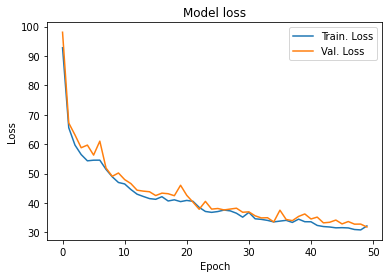

In [65]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train. Loss', 'Val. Loss'], loc='upper right')
plt.show()

## **Risultati Ottenuti**

Analizziamo il comportamento del modello sui dataset di test e valutiamone l'efficacia.

Per mantenere la coerenza tra le affermazioni riportate ed il risultato dell'esecuzione del codice, utilizziamo un modello pre-addestrato.


In [50]:
from keras.models import load_model

In [51]:
model_path = "models/Clip_Anomaly_Det_Autoencoder.h5"

model = Autoencoder(filename=model_path)
model.summary()

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_342 (Conv2D)             (None, 128, 128, 16) 160         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_343 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_342[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_76 (LeakyReLU)      (None, 128, 128, 16) 0           conv2d_343[0][0]                 
___________________________________________________________________________________________

Osserviamo prima di tutto i risultati della ricostruzione delle immagini.

In [52]:
def plot_rec_samples(image_generator, autoencoder, n):
    batch = image_generator.next()[0]

    predicted = autoencoder.predict(batch)
    _, axs = plt.subplots(n, 2, figsize=(8, 8))
    axs = axs.flatten()
    imgs = []

    for i in range(n):
        imgs.append(batch[i])
        imgs.append(predicted[i])

    for img, ax in zip(imgs, axs):
        img = img.reshape((128, 128))
        ax.imshow(img, cmap="gray")
    plt.show()

Esempio di ricostruzione su pezzi OK


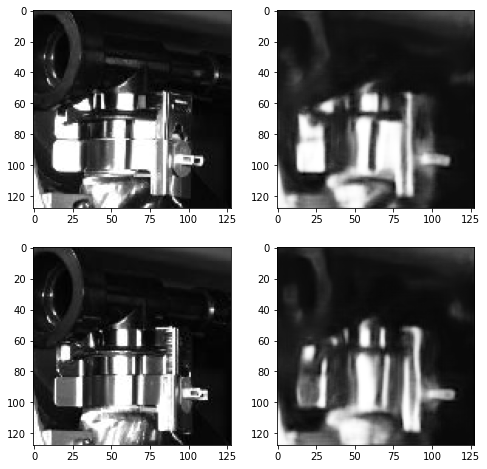

Esempio di ricostruzione su pezzi KO


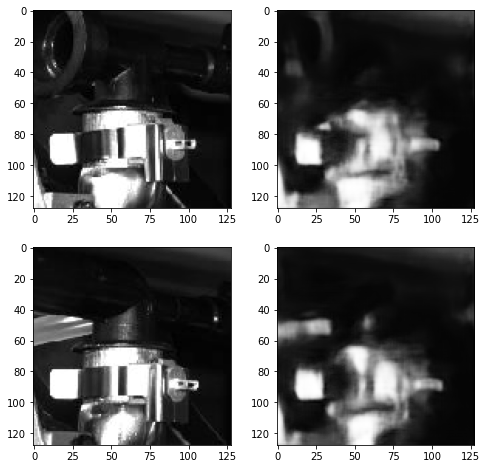

In [53]:
print("Esempio di ricostruzione su pezzi OK")
plot_rec_samples(test_generator, model.get_trained_autoencoder(), 2)

print("Esempio di ricostruzione su pezzi KO")
plot_rec_samples(anomaly_generator, model.get_trained_autoencoder(), 2)

Il modello così addestrato non è in grado di ricostruire perfettamente i dati originali, tuttavia è importante notare come le immagini ricostruite relative ai pezzi KO risultano maggiormente distorte rispetto alle ricostruzioni dei pezzi OK.

Analizziamo quindi gli errori di ricostruzione per determinare se tutto ciò si traduce in una differenza effettiva.

In [54]:
def plot_rec_error(image_generator, autoencoder, n = None):

  '''
  Mostra su grafico gli errori di ricostruzione di n immagini ottenute da un generatore.
  '''
    
  if n == None:
    n = image_generator.samples

  error_list = []
  processed = 0

  while processed < n:
    batch = image_generator.next()[0]
    for i in range(len(batch)):
        img = batch[i]
        img = img.reshape((1,128,128,1))
        # Calcolo dell'errore di ricostruzione
        rec_error = autoencoder.predict(img)
        error_list.append(rec_error)

        processed += 1

  print("min error:", min(error_list))
  print("max error:", max(error_list))

  plt.scatter(x = range(len(error_list)), y = sorted(error_list))
  plt.show()
  # plt.savefig("autoencoder_errore_test_set_augmented.png")
  return error_list

Errore di ricostruzione su pezzi OK
min error: 13.25727653503418
max error: 14.837593078613281


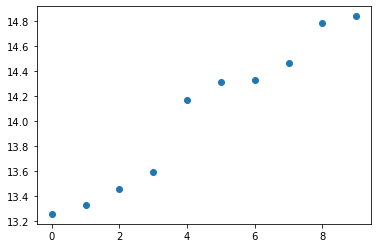

Errore di ricostruzione su pezzi KO
min error: 14.796867370605469
max error: 18.52878189086914


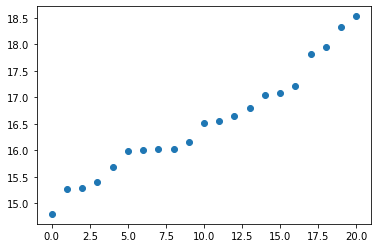

In [55]:
print("Errore di ricostruzione su pezzi OK")
test_generator.reset()
ok_err = plot_rec_error(test_generator, model.get_recostruction_error())

print("Errore di ricostruzione su pezzi KO")
anomaly_generator.reset()
ko_err = plot_rec_error(anomaly_generator, model.get_recostruction_error())

I grafici mostrano che l'errore commesso sui dati normali risulta mediamente inferiore rispetto a quello commesso sulle anomalie.

Utilizziamo un grafico ROC per determinare la soglia di errore ottimale.


In [56]:
def plot_ROC(upper_bound, lower_bound, delta, ok_err, ko_err):
  threshold = upper_bound

  tnr_list = []
  fnr_list = []
  th_list = []

  while threshold >= lower_bound:

    true_negative = sum(i < threshold for i in ok_err)
    false_negative = sum(i < threshold for i in ko_err)

    tn_rate = (true_negative / len(ok_err)) * 100
    fn_rate = (false_negative / len(ko_err)) * 100

    tnr_list.append(tn_rate)
    fnr_list.append(fn_rate)

    th_list.append(threshold)

    threshold -= delta


  plt.plot(fnr_list, tnr_list, 'bo-')
  plt.xlabel("False Negative Rate")
  plt.ylabel("True Negative Rate")

  for i, t in enumerate(th_list) :

      x,y = fnr_list[i], tnr_list[i]
      label = "{:.4f}".format(t)

      plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center
  plt.show()

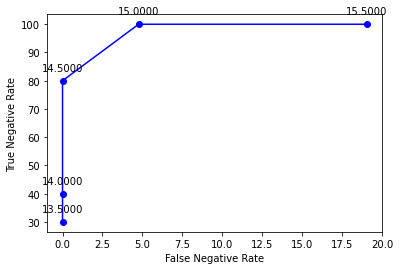

In [57]:
plot_ROC(15.5, 13.5, 0.5, ok_err, ko_err)

I risultati ottenuti sono incoraggianti, tuttavia vogliamo assicurarci di quanto la rete sia sensibile alle tolleranze di posizione delle clip metalliche, pertanto ripetiamo il calcolo dell'errore di ricostruzione, questa volta applicando funzioni di Data Augmentation sulle immagini di test e di anomalie.

In [58]:
augmented_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                               width_shift_range=0.05, 
                                                                               height_shift_range=0.05)
augmented_test_generator = augmented_test_datagen.flow_from_directory(
    data_path + "/test",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale")

augmented_anomaly_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=5.0, 
                                                                                  width_shift_range=0.05, 
                                                                                  height_shift_range=0.05)
augmented_anomaly_generator = augmented_anomaly_datagen.flow_from_directory(
    data_path + "/anomalies",
    batch_size=batch_size,
    target_size = (128, 128),
    color_mode = "grayscale" )

Found 10 images belonging to 1 classes.
Found 21 images belonging to 1 classes.


Errore di ricostruzione su pezzi OK
min error: 9.784317970275879
max error: 13.912692070007324


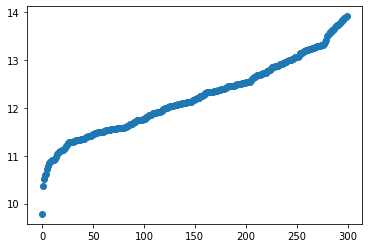

Errore di ricostruzione su pezzi KO
min error: 13.14857292175293
max error: 17.951026916503906


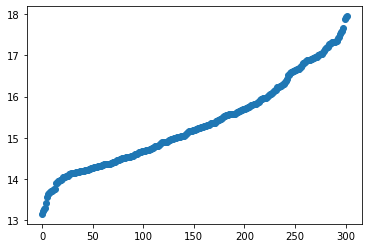

In [59]:
print("Errore di ricostruzione su pezzi OK")
augmented_test_generator.reset()
ok_err = plot_rec_error(augmented_test_generator, model.get_recostruction_error(), 300)

print("Errore di ricostruzione su pezzi KO")
augmented_anomaly_generator.reset()
ko_err = plot_rec_error(augmented_anomaly_generator, model.get_recostruction_error(), 300)

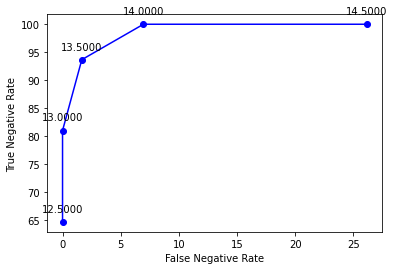

In [60]:
plot_ROC(14.5, 12.5, 0.5, ok_err, ko_err)

In [61]:
threshold = 13.0 # Soglia di errore

true_negative = sum(i < threshold for i in ok_err)
print("True Negative :", true_negative, "Over", len(ok_err))
print("True Negative Rate :", true_negative * 100 / len(ok_err))

false_negative = sum(i < threshold for i in ko_err)
print("False Negative :", false_negative, "Over", len(ko_err))
print("False Negative Rate :", false_negative * 100 / len(ko_err))

True Negative : 243 Over 300
True Negative Rate : 81.0
False Negative : 0 Over 302
False Negative Rate : 0.0


Anche in questo caso il modello è in grado di riconoscere tutte le immagini di pezzi KO come anomalie, mantenedo una accuratezza di circa l'80% sui pezzi OK.